# **Preparation Agent**

Our preparation agent will be the first entity which loads the data from the data path. It will perform all necessary data preparation steps on the data which are needed for all subsequent agents.

To build our recommender system, we use the REFIT: Electrical Load Measurements provided by Murray et al. (2017). The data contains the energy consumption of nine different devices in Watts used in 20 households in the United Kingdom as well as the aggregate energy consumption in each household over the period 2013 to 2015. As the data only contains these energy consumption measured at eight-second intervals, we need to perform a few preparation steps including aggregating the data, cleaning the data, creating our target features and further feature creation. 

We will create a class for the preparation agent which will include relevant functions and steps for the data preparation. At the end, we will introduce pipeline functions for each subsequent agent, such that the following agents can perform all relevant preparation steps for the respective task just by calling one pipeline function. This preparation agent approach allows us to re-use code efficiently and prevents duplicate implementations of preparation functionality in the subsequent agents.

Throughout the course of this notebook, we will define the Preparation-Agent class, iteratively add necessary functionality, explain each introduced step and define the final pipeline functions. 

The complete Preparation-Agent class definition can be found in the appendix to this notebook. The class can be loaded into further jupyter notebooks using the agents.py file.

## **1. Preparing the Environment**

For the purpose of demonstrating the functionality of the Preparation Agent, we will load the data for household one and apply our preparation steps to the data. 

In [1]:
# load necessary libraries
import pandas as pd
import numpy as np

from helper_functions import Helper

helper = Helper()

In [2]:
DATA_PATH = '../data/'

In [3]:
# loading the REFIT household data - The helper function will assign the correct labels
household_id = 1
household = helper.load_household(DATA_PATH, household_id)
household

,Time,Unix,Aggregate,Fridge,Chest Freezer,Upright Freezer,Tumble Dryer,Washing Machine,Dishwasher,Computer Site,Television Site,Electric Heater,Issues
Time,,,,,,,,,,,,,
2013-10-09 13:06:17,2013-10-09 13:06:17,1381323977,523,74,0,69,0,0,0,0,0,1,0
2013-10-09 13:06:31,2013-10-09 13:06:31,1381323991,526,75,0,69,0,0,0,0,0,1,0
2013-10-09 13:06:46,2013-10-09 13:06:46,1381324006,540,74,0,68,0,0,0,0,0,1,0
2013-10-09 13:07:01,2013-10-09 13:07:01,1381324021,532,74,0,68,0,0,0,0,0,1,0
2013-10-09 13:07:15,2013-10-09 13:07:15,1381324035,540,74,0,69,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-10 11:56:05,2015-07-10 11:56:05,1436529365,187,0,45,0,0,0,0,0,0,1,0
2015-07-10 11:56:12,2015-07-10 11:56:12,1436529372,185,0,45,0,0,0,0,0,0,1,0
2015-07-10 11:56:18,2015-07-10 11:56:18,1436529378,181,0,45,0,0,0,0,0,0,1,0


## **2. Creating the Preparation Agent**

### **2.1 Defining the Preparation Agent Class** 

At first, our Preparation Agent class will only contain the initialization function. Our agents will always require the respective input data for initializing. Therefore, we are always able to compare the output of the agent to its respective data input. In the case of the Preparation Agent, we will use the REFIT data as input data.


In [4]:
# Create class for the Preparation Agent

# the class will be extended during this notebook
# the complete class definition can be found in the appendix

class Preparation_Agent:

    def __init__(self, REFIT_df):
        self.input = REFIT_df

In [5]:
prep = Preparation_Agent(household)
prep.input.describe().round(2)

,Unix,Aggregate,Fridge,Chest Freezer,Upright Freezer,Tumble Dryer,Washing Machine,Dishwasher,Computer Site,Television Site,Electric Heater,Issues
count,6.960008e+06,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00
mean,1.409144e+09,481.14,17.54,16.55,29.01,1.84,11.03,11.16,2.47,5.80,69.48,0.01
std,1.579852e+07,812.89,43.09,28.84,38.01,56.11,143.92,156.79,11.93,13.17,255.80,0.09
min,1.381324e+09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.396639e+09,185.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
50%,1.409931e+09,242.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
75%,1.422401e+09,427.00,0.00,45.00,70.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
max,1.436529e+09,29159.00,3584.00,3452.00,3657.00,3584.00,3072.00,2525.00,2094.00,3584.00,2119.00,1.00


In [6]:
# Missing values
prep.input.isna().sum()

Time               0
Unix               0
Aggregate          0
Fridge             0
Chest Freezer      0
Upright Freezer    0
Tumble Dryer       0
Washing Machine    0
Dishwasher         0
Computer Site      0
Television Site    0
Electric Heater    0
Issues             0
dtype: int64

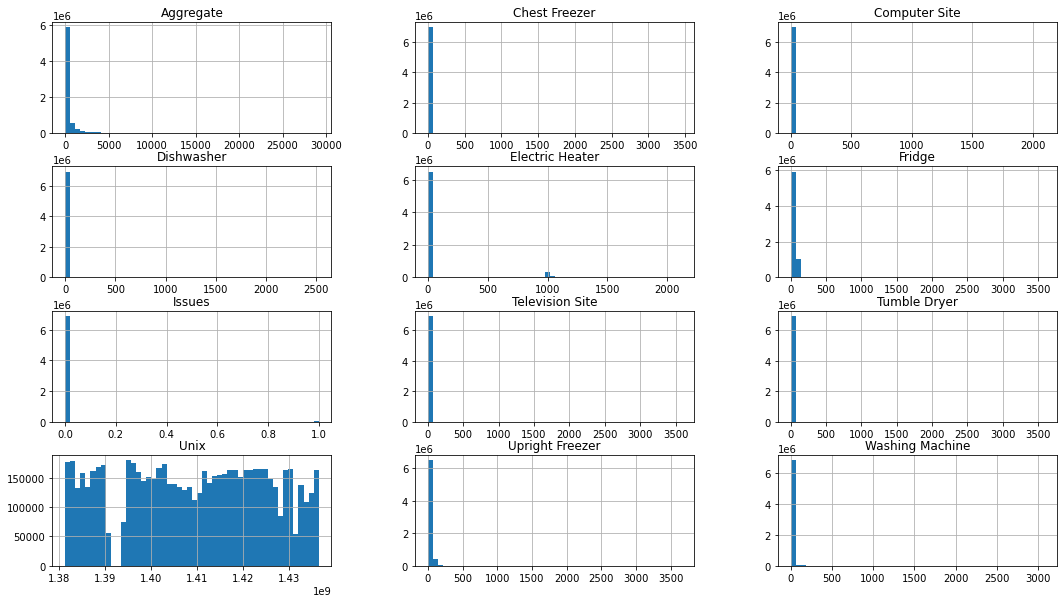

In [7]:
# Histogram
prep.input.hist(bins=50, figsize=(18,10));

### **2.2 Standard Data-Preprocessing**

After having a quick look at the data, we observed no missing values, skewed data and a few outliers. The skewness is due to the fact, that the appliances are often turned off and do not consume any or a small amount of energy. As we are only interested in the times when an appliance is used and hence consumes more energy, this will not be a problem. Regarding the outliers of energy consumption, we will apply a small outlier truncation function to the data. 

Furthermore, as we will use a threshold value of energy consumption for each appliance to determine if an appliance is used or not, we will scale the data to the same interval. We will use a Min-Max scaler which scales the data to the [0, 1]-interval. Due to the same scaling of each appliance, we are able to apply the same threshold values of energy consumption to all appliances.


**Outlier Truncation**

In [8]:
def outlier_truncation(self, series, factor=1.5, verbose=0):
    from tqdm import tqdm
    
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3-q1
    
    lower_bound = q1 - factor*iqr
    upper_bound = q3 + factor*iqr
    
    output = []
    counter = 0
    for item in (tqdm(series, desc=f'[outlier truncation: {series.name}]') if verbose != 0 else series):
        if item > upper_bound:
            output.append(int(upper_bound))
            counter += 1
        elif item < lower_bound:
            output.append(int(lower_bound))
            counter += 1
        else:
            output.append(item)
    print(f'[outlier truncation: {series.name}]: {counter} outliers were truncated.') if verbose != 0 else None 
    return output

# add the function to the class and delete global function
setattr(Preparation_Agent, 'outlier_truncation', outlier_truncation)
del outlier_truncation

In [9]:
df = pd.DataFrame()
df['Aggregate'] = household['Aggregate'].copy()

prep = Preparation_Agent(household)
df['Aggregate_truncated'] = prep.outlier_truncation(prep.input['Aggregate'], verbose = 1)
df.describe().round(2)

[outlier truncation: Aggregate]: 100%|██████████| 6960008/6960008 [00:08<00:00, 793490.11it/s] 


[outlier truncation: Aggregate]: 853913 outliers were truncated.


,Aggregate,Aggregate_truncated
count,6960008.00,6960008.00
mean,481.14,338.49
std,812.89,209.41
min,0.00,0.00
25%,185.00,185.00
50%,242.00,242.00
75%,427.00,427.00
max,29159.00,790.00


In [10]:
# truncating multiple features
def truncate(self, df, features='all', factor=1.5, verbose=0):
    import time
    output = df.copy()
    features = df.select_dtypes(include=['int', 'float']).columns if features == 'all' else features

    for feature in features:
        time.sleep(0.2) if verbose != 0 else None
        row_nn = df[feature] != 0                                                                  # truncate only the values for which the device uses energy
        output.loc[row_nn, feature] = self.outlier_truncation(df.loc[row_nn, feature], factor=factor, verbose=verbose) # Truncatation factor = 1.5 * IQR
        print('\n') if verbose != 0 else None
    return output

# add to class
setattr(Preparation_Agent, 'truncate', truncate)
del truncate

In [11]:
prep = Preparation_Agent(household)
household_t = prep.truncate(household, verbose=1)
household_t.describe().round(2)

[outlier truncation: Unix]: 100%|██████████| 6960008/6960008 [00:11<00:00, 614955.44it/s] 


[outlier truncation: Unix]: 0 outliers were truncated.




[outlier truncation: Aggregate]: 100%|██████████| 6959964/6959964 [00:10<00:00, 637030.97it/s] 


[outlier truncation: Aggregate]: 853913 outliers were truncated.




[outlier truncation: Fridge]: 100%|██████████| 1611328/1611328 [00:01<00:00, 852907.35it/s]


[outlier truncation: Fridge]: 60120 outliers were truncated.




[outlier truncation: Chest Freezer]: 100%|██████████| 2395354/2395354 [00:04<00:00, 538421.41it/s]


[outlier truncation: Chest Freezer]: 207420 outliers were truncated.




[outlier truncation: Upright Freezer]: 100%|██████████| 2800342/2800342 [00:04<00:00, 641238.13it/s]


[outlier truncation: Upright Freezer]: 197818 outliers were truncated.




[outlier truncation: Tumble Dryer]: 100%|██████████| 28117/28117 [00:00<00:00, 862726.38it/s]


[outlier truncation: Tumble Dryer]: 5934 outliers were truncated.




[outlier truncation: Washing Machine]: 100%|██████████| 156232/156232 [00:00<00:00, 1075178.11it/s]


[outlier truncation: Washing Machine]: 27412 outliers were truncated.




[outlier truncation: Dishwasher]: 100%|██████████| 65272/65272 [00:00<00:00, 948070.79it/s]


[outlier truncation: Dishwasher]: 0 outliers were truncated.




[outlier truncation: Computer Site]: 100%|██████████| 756639/756639 [00:00<00:00, 1100282.31it/s]


[outlier truncation: Computer Site]: 253600 outliers were truncated.




[outlier truncation: Television Site]: 100%|██████████| 1273899/1273899 [00:01<00:00, 1176501.08it/s]


[outlier truncation: Television Site]: 225564 outliers were truncated.




[outlier truncation: Electric Heater]: 100%|██████████| 6899335/6899335 [00:05<00:00, 1192257.63it/s]


[outlier truncation: Electric Heater]: 473668 outliers were truncated.




[outlier truncation: Issues]: 100%|██████████| 58183/58183 [00:00<00:00, 966993.27it/s]


[outlier truncation: Issues]: 0 outliers were truncated.




,Unix,Aggregate,Fridge,Chest Freezer,Upright Freezer,Tumble Dryer,Washing Machine,Dishwasher,Computer Site,Television Site,Electric Heater,Issues
count,6.960008e+06,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00
mean,1.409144e+09,338.49,17.34,16.14,28.47,1.39,5.00,11.16,2.70,5.82,0.99,0.01
std,1.579852e+07,209.41,31.76,22.33,34.74,38.57,51.44,156.79,8.14,12.36,0.09,0.09
min,1.381324e+09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.396639e+09,185.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
50%,1.409931e+09,242.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
75%,1.422401e+09,427.00,0.00,45.00,70.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
max,1.436529e+09,790.00,95.00,52.00,76.00,1268.00,733.00,2525.00,37.00,37.00,1.00,1.00


**MinMaxScaling**

In [12]:
def scale(self, df, features='all', kind='MinMax', verbose=0):
    output = df.copy()
    features = df.select_dtypes(include=['int', 'float']).columns if features == 'all' else features
    
    if kind == 'MinMax':
        from sklearn.preprocessing import MinMaxScaler
        
        scaler = MinMaxScaler()
        output[features] = scaler.fit_transform(df[features])
        print('[MinMaxScaler] Finished scaling the data.') if verbose != 0 else None
    else:
        raise InputError('Chosen scaling method is not available.')
    return output 

# add to the class
setattr(Preparation_Agent, 'scale', scale)
del scale

In [13]:
prep = Preparation_Agent(household)
household_s = prep.scale(household_t, verbose=1)

[MinMaxScaler] Finished scaling the data.


In [14]:
household_s.describe().round(2)

,Unix,Aggregate,Fridge,Chest Freezer,Upright Freezer,Tumble Dryer,Washing Machine,Dishwasher,Computer Site,Television Site,Electric Heater,Issues
count,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00,6960008.00
mean,0.50,0.43,0.18,0.31,0.37,0.00,0.01,0.00,0.07,0.16,0.99,0.01
std,0.29,0.27,0.33,0.43,0.46,0.03,0.07,0.06,0.22,0.33,0.09,0.09
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.28,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
50%,0.52,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
75%,0.74,0.54,0.00,0.87,0.92,0.00,0.00,0.00,0.00,0.00,1.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### **2.3 Feature Creation**

For more accurate predictions and recommendations, we will create further features derived from the REFIT data. The feature creation of the preparation agent could easily be expanded by defining further feature creation functions and adding the newly created functions to the respective pipeline functions. Furthermore, our target variables for the activity agent and the usage agent will be created.


**Note:** For the purpose of demonstrating the functionality of the preparation agent’s functions, we will reduce the data to one day, aggregate the data to the hour level and plot the consumption using our helper functions. 


In [15]:
def get_timespan(self, df, start, timedelta_params):
    start = pd.to_datetime(start) if type(start) != type(pd.to_datetime('1970-01-01')) else start 
    end = start + pd.Timedelta(**timedelta_params)
    return df[start:end]

# add to the helper class
setattr(Helper, 'get_timespan', get_timespan)
del get_timespan

In [16]:
# Extracting data for one day
helper = Helper()

timedelta_params = {'days': 1, 'seconds': -1}   # returns data for just one day
day = helper.get_timespan(household_s, '2014-01-01', timedelta_params)
day

,Time,Unix,Aggregate,Fridge,Chest Freezer,Upright Freezer,Tumble Dryer,Washing Machine,Dishwasher,Computer Site,Television Site,Electric Heater,Issues
Time,,,,,,,,,,,,,
2014-01-01 00:00:02,2014-01-01 00:00:02,0.130611,0.827848,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.810811,1.0,0.0
2014-01-01 00:00:16,2014-01-01 00:00:16,0.130611,0.832911,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.810811,1.0,0.0
2014-01-01 00:00:17,2014-01-01 00:00:17,0.130611,0.832911,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.810811,1.0,0.0
2014-01-01 00:00:18,2014-01-01 00:00:18,0.130611,0.836709,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.810811,1.0,0.0
2014-01-01 00:00:31,2014-01-01 00:00:31,0.130611,0.829114,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.810811,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-01-01 23:59:29,2014-01-01 23:59:29,0.132175,0.232911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0
2014-01-01 23:59:31,2014-01-01 23:59:31,0.132175,0.232911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0
2014-01-01 23:59:33,2014-01-01 23:59:33,0.132175,0.231646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0


In [17]:
# aggregates the data to meet different time period requirements by calculating the mean over the time period
def aggregate(self, df, resample_param):
    return df.resample(resample_param).mean().copy()

# add to the helper class
setattr(Helper, 'aggregate', aggregate)
del aggregate

In [18]:
helper = Helper()
day = helper.aggregate(day, '60T')
day

,Unix,Aggregate,Fridge,Chest Freezer,Upright Freezer,Tumble Dryer,Washing Machine,Dishwasher,Computer Site,Television Site,Electric Heater,Issues
Time,,,,,,,,,,,,
2014-01-01 00:00:00,0.130645,0.984763,0.354334,0.269731,0.492345,0.0,0.000000,0.0,0.000000,0.743746,1.000000,0.003717
2014-01-01 01:00:00,0.130711,1.000000,0.000000,0.284147,0.750075,0.0,0.000000,0.0,0.000000,0.067362,1.000000,0.000000
2014-01-01 02:00:00,0.130774,1.000000,0.390838,0.250194,0.206805,0.0,0.000000,0.0,0.000000,0.597552,1.000000,0.001684
2014-01-01 03:00:00,0.130839,1.000000,0.000000,0.249936,0.233410,0.0,0.000002,0.0,0.000000,0.158275,1.000000,0.000000
2014-01-01 04:00:00,0.130904,1.000000,0.036948,0.247806,0.410875,0.0,0.164974,0.0,0.000000,0.000000,1.000000,0.025168
2014-01-01 05:00:00,0.130970,0.490481,0.345019,0.254259,0.403259,0.0,0.035388,0.0,0.000000,0.000000,1.000000,0.026846
2014-01-01 06:00:00,0.131035,0.280193,0.000000,0.247645,0.393501,0.0,0.000002,0.0,0.000000,0.000000,1.000000,0.000000
2014-01-01 07:00:00,0.131100,0.267747,0.326316,0.245485,0.296853,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
2014-01-01 08:00:00,0.131165,0.340665,0.063748,0.244645,0.190399,0.0,0.000000,0.0,0.000000,0.602441,1.000000,0.000000


In [19]:
def plot_consumption(self, df, features='all', figsize='default', threshold=None, title='Consumption'):
    import matplotlib.pyplot as plt

    df = df.copy()
    features = [column for column in df.columns if column not in ['Unix', 'Issues']] if features == 'all' else features

    fig, ax = plt.subplots(figsize=figsize) if figsize != 'default' else plt.subplots()
    if threshold != None:
        df['threshold'] = [threshold]*df.shape[0]
        ax.plot(df['threshold'], color = 'tab:red')
    for feature in features:
        ax.plot(df[feature])
    ax.legend(['threshold'] + features) if threshold != None else ax.legend(features)
    ax.set_title(title);

# add to the helper class
setattr(Helper, 'plot_consumption', plot_consumption)
del plot_consumption

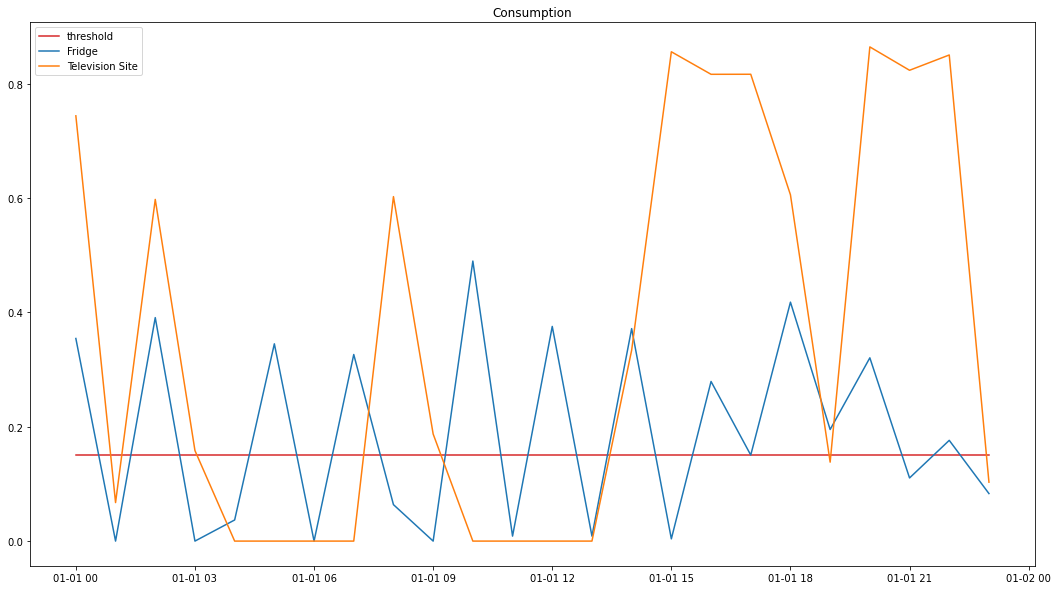

In [20]:
helper = Helper()
helper.plot_consumption(day, figsize=(18,10), threshold=.15, features=['Fridge', 'Television Site'])

**Device Usage Features**

A binary device usage variable will be intoduced, so that we will be able to analyse at which times a device was used by the user. A positive value will indicate that the device is used in a given period. A negative value will indicate that the device was not used. 

The device usage feature will be based on the scaled energy consumption of each device. The feature will be positive if the scaled consumption exceeds the pre-defined threshold to account for noise in the consumtion data (i.e. sudden consumption peaks during times a device is shut down due to sensor errors). The optimal threshold will be determined via a graphical analysis in a later part of the notebook.

After the creation of the device usage variable, we introduce a further device usage feature. The get last usages functions will create a feature will specifies how many periods passed since the last device usage.


In [21]:
def get_device_usage(self, df, device, threshold):
    return (df.loc[:, device] > threshold).astype('int')

# add to class
setattr(Preparation_Agent, 'get_device_usage', get_device_usage)
del get_device_usage

In [22]:
# hourly usage of device 'Television Site' in the household on Jan 1, 2014
prep = Preparation_Agent(household)
prep.get_device_usage(day, 'Television Site', .15)

Time
2014-01-01 00:00:00    1
2014-01-01 01:00:00    0
2014-01-01 02:00:00    1
2014-01-01 03:00:00    1
2014-01-01 04:00:00    0
2014-01-01 05:00:00    0
2014-01-01 06:00:00    0
2014-01-01 07:00:00    0
2014-01-01 08:00:00    1
2014-01-01 09:00:00    1
2014-01-01 10:00:00    0
2014-01-01 11:00:00    0
2014-01-01 12:00:00    0
2014-01-01 13:00:00    0
2014-01-01 14:00:00    1
2014-01-01 15:00:00    1
2014-01-01 16:00:00    1
2014-01-01 17:00:00    1
2014-01-01 18:00:00    1
2014-01-01 19:00:00    0
2014-01-01 20:00:00    1
2014-01-01 21:00:00    1
2014-01-01 22:00:00    1
2014-01-01 23:00:00    0
Freq: 60T, Name: Television Site, dtype: int64

In [23]:
# daily appliance usage
days = helper.aggregate(household_s, '1D')
active_appliances = ['Tumble Dryer', 'Washing Machine', 'Dishwasher', 'Computer Site', 'Television Site']

for appliance in active_appliances:
    days[appliance + '_usage'] = prep.get_device_usage(days, appliance, 0)

usage_cols = [column for column in days.columns if column.endswith('_usage')]
days[usage_cols]

,Tumble Dryer_usage,Washing Machine_usage,Dishwasher_usage,Computer Site_usage,Television Site_usage
Time,,,,,
2013-10-09,1,0,0,0,1
2013-10-10,1,0,1,1,1
2013-10-11,0,0,0,0,1
2013-10-12,0,0,0,0,1
2013-10-13,0,0,0,0,1
...,...,...,...,...,...
2015-07-06,1,0,1,1,1
2015-07-07,0,0,0,1,1
2015-07-08,0,1,1,1,1


In [24]:
days[usage_cols].describe()

,Tumble Dryer_usage,Washing Machine_usage,Dishwasher_usage,Computer Site_usage,Television Site_usage
count,640.000000,640.000000,640.000000,640.000000,640.000000
mean,0.371875,0.504687,0.293750,0.660937,0.896875
std,0.483683,0.500369,0.455835,0.473761,0.304360
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


**Periods Since the Last Device Usage**

In [25]:
def get_last_usage(self, series):
    last_usage = []
    for idx in range(len(series)):
        shift = 1
        if pd.isna(series.shift(periods = 1)[idx]):
            shift = None
        else:
            while series.shift(periods = shift)[idx] == 0:
                shift += 1
        last_usage.append(shift)
    return last_usage

def get_last_usages(self, df, features):
    import pandas as pd

    output = pd.DataFrame()
    for feature in features:
        output['periods_since_last_'+feature] = self.get_last_usage(df[feature])
    output.set_index(df.index, inplace=True)
    return output


setattr(Preparation_Agent, 'get_last_usage', get_last_usage)
del get_last_usage

setattr(Preparation_Agent, 'get_last_usages', get_last_usages)
del get_last_usages

In [26]:
usage_cols = [column for column in days.columns if column.endswith('_usage')]

prep = Preparation_Agent(household)
days = days.join(prep.get_last_usages(days, usage_cols))
days.iloc[:, -10:]

,Tumble Dryer_usage,Washing Machine_usage,Dishwasher_usage,Computer Site_usage,Television Site_usage,periods_since_last_Tumble Dryer_usage,periods_since_last_Washing Machine_usage,periods_since_last_Dishwasher_usage,periods_since_last_Computer Site_usage,periods_since_last_Television Site_usage
Time,,,,,,,,,,
2013-10-09,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN
2013-10-10,1,0,1,1,1,1.0,2.0,2.0,2.0,1.0
2013-10-11,0,0,0,0,1,1.0,3.0,1.0,1.0,1.0
2013-10-12,0,0,0,0,1,2.0,4.0,2.0,2.0,1.0
2013-10-13,0,0,0,0,1,3.0,5.0,3.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2015-07-06,1,0,1,1,1,16.0,1.0,3.0,1.0,1.0
2015-07-07,0,0,0,1,1,1.0,2.0,1.0,1.0,1.0
2015-07-08,0,1,1,1,1,2.0,3.0,2.0,1.0,1.0


**Activity Feature**

The activity feature needed for activity prediction in the household will be based on the usage of appliances which need user interaction, the so called “active appliances”. For each period, in which at least one of the active appliances is used, the user will be classified as active. The new feature will be a binary variable. A positive value of the activity feature will indicate that the user used some appliance which requires user interaction within a given period.

As each household contains different appliances, the active appliances need to be defined manually for each household. For household one we defined as active appliances: „Tumble Dryer”, „Washing Machine“, „Dishwasher“, „Computer Site“ and „Television Site“

In [27]:
# select appliances which require user interaction --> active appliances
print(list(household.columns))

active_appliances = ['Tumble Dryer', 'Washing Machine', 'Dishwasher', 'Computer Site', 'Television Site']

['Time', 'Unix', 'Aggregate', 'Fridge', 'Chest Freezer', 'Upright Freezer', 'Tumble Dryer', 'Washing Machine', 'Dishwasher', 'Computer Site', 'Television Site', 'Electric Heater', 'Issues']


In [28]:
def get_activity(self, df, active_appliances, threshold):
    import pandas as pd

    active = pd.DataFrame({appliance: df[appliance] > threshold for appliance in active_appliances})
    return active.apply(any, axis = 1).astype('int')

# add to the Preparation_agent class
setattr(Preparation_Agent, 'get_activity', get_activity)
del get_activity

In [29]:
prep = Preparation_Agent(household)
day['activity'] = prep.get_activity(day, active_appliances, .15)
day

,Unix,Aggregate,Fridge,Chest Freezer,Upright Freezer,Tumble Dryer,Washing Machine,Dishwasher,Computer Site,Television Site,Electric Heater,Issues,activity
Time,,,,,,,,,,,,,
2014-01-01 00:00:00,0.130645,0.984763,0.354334,0.269731,0.492345,0.0,0.000000,0.0,0.000000,0.743746,1.000000,0.003717,1
2014-01-01 01:00:00,0.130711,1.000000,0.000000,0.284147,0.750075,0.0,0.000000,0.0,0.000000,0.067362,1.000000,0.000000,0
2014-01-01 02:00:00,0.130774,1.000000,0.390838,0.250194,0.206805,0.0,0.000000,0.0,0.000000,0.597552,1.000000,0.001684,1
2014-01-01 03:00:00,0.130839,1.000000,0.000000,0.249936,0.233410,0.0,0.000002,0.0,0.000000,0.158275,1.000000,0.000000,1
2014-01-01 04:00:00,0.130904,1.000000,0.036948,0.247806,0.410875,0.0,0.164974,0.0,0.000000,0.000000,1.000000,0.025168,1
2014-01-01 05:00:00,0.130970,0.490481,0.345019,0.254259,0.403259,0.0,0.035388,0.0,0.000000,0.000000,1.000000,0.026846,0
2014-01-01 06:00:00,0.131035,0.280193,0.000000,0.247645,0.393501,0.0,0.000002,0.0,0.000000,0.000000,1.000000,0.000000,0
2014-01-01 07:00:00,0.131100,0.267747,0.326316,0.245485,0.296853,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0
2014-01-01 08:00:00,0.131165,0.340665,0.063748,0.244645,0.190399,0.0,0.000000,0.0,0.000000,0.602441,1.000000,0.000000,1


**Time Features Based on DatetimeIndex**

To create simple time features for our data, we create a further function. The function will allow us to extract multiple features from the DatetimeIndex. 


In [30]:
def get_time_feature(self, df, features='all'):
    import pandas as pd
    
    functions = {
        'hour': lambda df: df.index.hour, 
        'day_of_week': lambda df: df.index.dayofweek,
        'day_name': lambda df: df.index.day_name().astype('category'),
        'month': lambda df: df.index.month, 
        'month_name': lambda df: df.index.month_name().astype('category'),
        'weekend': lambda df: [int(x in ['Saturday', 'Sunday']) for x in  list(df.index.day_name())]
    }
    if features == 'all':
        output = pd.DataFrame({function[0]: function[1](df) for function in functions.items()})
    else:
        output = pd.DataFrame({function[0]: function[1](df) for function in functions.items() if function[0] in features})
    output.set_index(df.index, inplace=True)
    return output

# add to the Preparation_agent class
setattr(Preparation_Agent, 'get_time_feature', get_time_feature)
del get_time_feature

In [31]:
prep.get_time_feature(day)
day = day.join(prep.get_time_feature(day))
day.iloc[:, -6:]

,hour,day_of_week,day_name,month,month_name,weekend
Time,,,,,,
2014-01-01 00:00:00,0,2,Wednesday,1,January,0
2014-01-01 01:00:00,1,2,Wednesday,1,January,0
2014-01-01 02:00:00,2,2,Wednesday,1,January,0
2014-01-01 03:00:00,3,2,Wednesday,1,January,0
2014-01-01 04:00:00,4,2,Wednesday,1,January,0
2014-01-01 05:00:00,5,2,Wednesday,1,January,0
2014-01-01 06:00:00,6,2,Wednesday,1,January,0
2014-01-01 07:00:00,7,2,Wednesday,1,January,0
2014-01-01 08:00:00,8,2,Wednesday,1,January,0


**Time Lag Features**

Further time features will be introduced by our time lag function. The time lag function will create a time shift for the given periods and features. 

In [32]:
def get_time_lags(self, df, features, lags):
    import pandas as pd

    output = pd.DataFrame()
    for feature in features:
        for lag in lags:
            output[f'{feature}_lag_{lag}'] = df[feature].shift(periods=lag)
    return output

# add to the Preparation_agent class
setattr(Preparation_Agent, 'get_time_lags', get_time_lags)
del get_time_lags

In [33]:
day = day.join(prep.get_time_lags(day, ['activity', 'hour'], [1, 2, 5]))
day.iloc[:, -6:]

,activity_lag_1,activity_lag_2,activity_lag_5,hour_lag_1,hour_lag_2,hour_lag_5
Time,,,,,,
2014-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 01:00:00,1.0,NaN,NaN,0.0,NaN,NaN
2014-01-01 02:00:00,0.0,1.0,NaN,1.0,0.0,NaN
2014-01-01 03:00:00,1.0,0.0,NaN,2.0,1.0,NaN
2014-01-01 04:00:00,1.0,1.0,NaN,3.0,2.0,NaN
2014-01-01 05:00:00,1.0,1.0,1.0,4.0,3.0,0.0
2014-01-01 06:00:00,0.0,1.0,0.0,5.0,4.0,1.0
2014-01-01 07:00:00,0.0,0.0,1.0,6.0,5.0,2.0
2014-01-01 08:00:00,0.0,0.0,1.0,7.0,6.0,3.0


### **2.4 Determining the Optimal Threshold**


One drawback of defining device usage and user activity based on energy consumption of appliances measured by sensors is that these sensors can create noise in the data. For example, some sensors recorded sudden high consumption peaks during times in which the appliance was turned off. To reduce the impact of the noise created by sensor errors, we determine the device usage and activity features based on a threshold. Only if the average consumption during a period exceeds the threshold, we will recognize the energy consumption as device usage and activity. However, setting the threshold too high will result in actual device usage and activity not being detected. Therefore, our goal is to find an optimal threshold, which is as small as possible but still accounts for any noise in the data.

<br>

<img src='https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-019-43007-x/MediaObjects/41598_2019_43007_Fig3_HTML.png?as=webp'  alt='Wennmann et al. (2019),  Figure 3 - Hourly pattern of physical activity by weekday. Upper figure men, lower figure women.'  width=500>

**Figure 1:** Hourly pattern of physical activity by weekday. Upper figure men, lower figure women. (Wennmann et al., 2019, Figure 3).

<br>

To identify the optimal threshold, we applied a graphical analysis which tests different thresholds and plots the device usage and the user activity against different aggregated time features. As a benchmark for the activity, we chose the results from Wennman et al. (2019).

<br>

<img src='https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-019-43007-x/MediaObjects/41598_2019_43007_Fig4_HTML.png?as=webp'  alt='Wennmann et al. (2019),  Figure 4 - Hourly patterns of physical activity by employment status (upper figure) and education (lower figure).'  width=500>

**Figure 2:** Hourly patterns of physical activity by employment status (upper figure) and education (lower figure). (Wennmann et al., 2019 , Figure 4).

<br>

Our will optimal threshold will be the smallest threshold for which the activity feature coincides with our benchmark and no further noise can be identified.


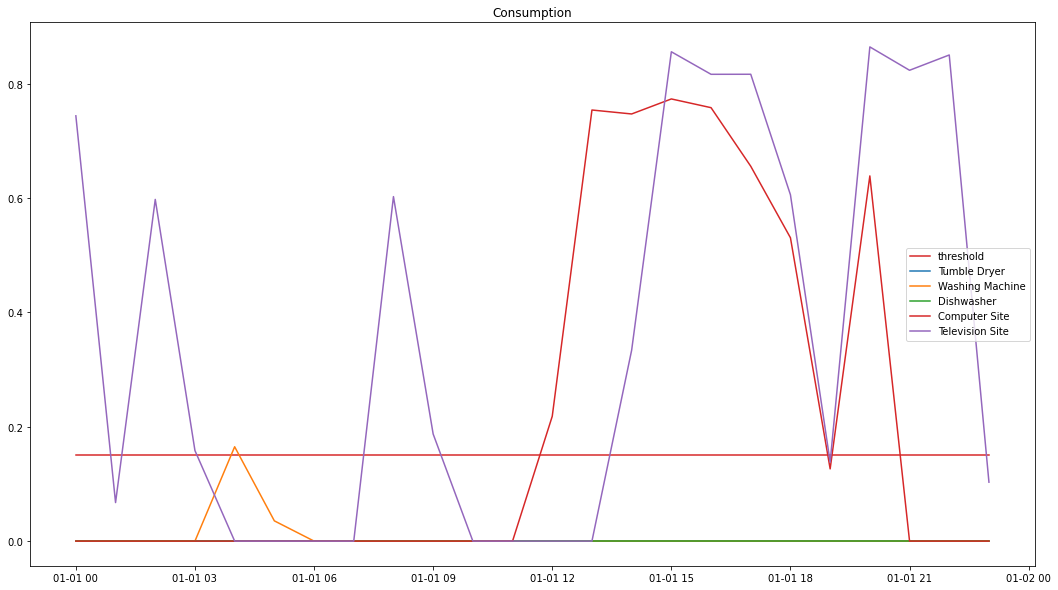

In [34]:
helper.plot_consumption(day, active_appliances, figsize=(18,10), threshold=.15)

In [35]:
def visualize_threshold(self, df, threshold, appliances, figsize=(18,5)):
    # data prep
    for appliance in appliances:
        df[appliance + '_usage'] = self.get_device_usage(df, appliance, threshold)
    df = df.join(self.get_time_feature(df))
    df['activity'] = self.get_activity(df, appliances, threshold)

    # plotting 
    import matplotlib.pyplot as plt

    usage_cols = [column for column in df.columns if column.endswith('_usage')]
    columns = ['activity'] + usage_cols

    fig, axes = plt.subplots(1,3, figsize=figsize)

    # hour
    hour = df.groupby('hour').mean()[columns]
    hour.plot(ax=axes[0])
    axes[0].set_ylim(-.1, 1.1);
    axes[0].set_title(f'[threshold: {round(threshold, 4)}] Activity ratio per hour')

    # week 
    usage_cols = [column for column in df.columns if column.endswith('_usage')]
    week = df.groupby('day_name').mean()[columns]
    week = week.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    week.plot(ax=axes[1])
    axes[1].set_ylim(-.1, 1.1);
    axes[1].set_xticklabels(['']+list(week.index), rotation=90)
    axes[1].set_title(f'[threshold: {round(threshold, 4)}] Activity ratio per day of the week')

    # month
    usage_cols = [column for column in df.columns if column.endswith('_usage')]
    month = df.groupby('month').mean()[columns]
    month.plot(ax=axes[2])
    axes[2].set_ylim(-.1, 1.1);
    axes[2].set_title(f'[threshold: {round(threshold, 4)}] Activity ratio per month')

# add to the Preparation_agent class
setattr(Preparation_Agent, 'visualize_threshold', visualize_threshold)
del visualize_threshold

In [36]:
def validate_thresholds(self, df, thresholds, appliances, figsize=(18,5)):
    import time
    from tqdm import tqdm
    for threshold in tqdm(thresholds):
        self.visualize_threshold(df, threshold, appliances, figsize)
    time.sleep(0.2)
    print('\n')

# add to the Preparation_agent class
setattr(Preparation_Agent, 'validate_thresholds', validate_thresholds)
del validate_thresholds

100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


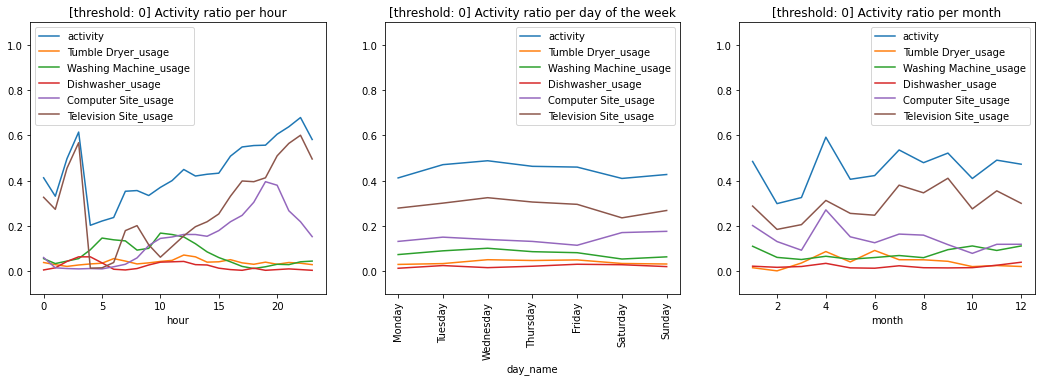

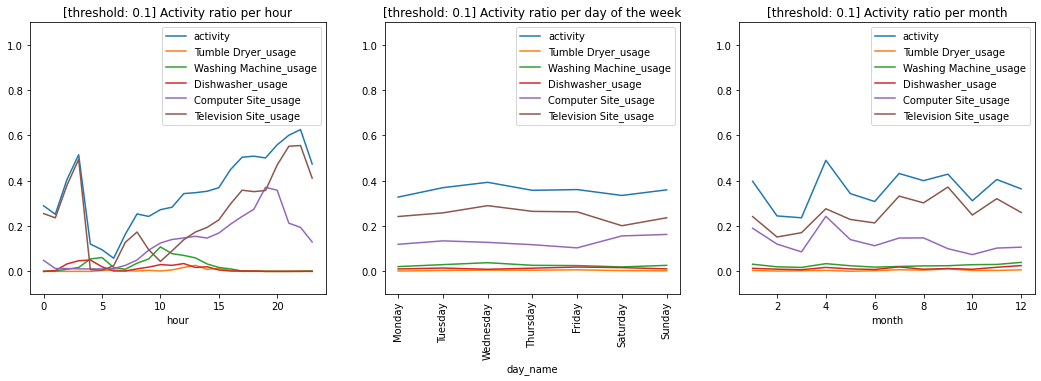

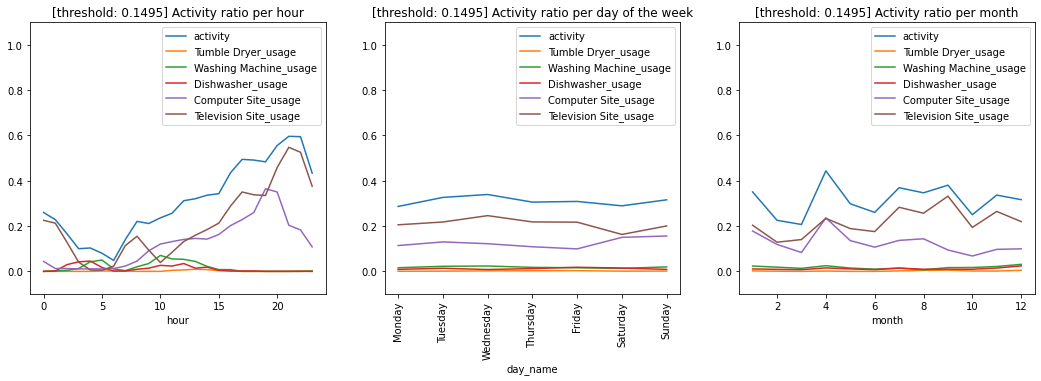

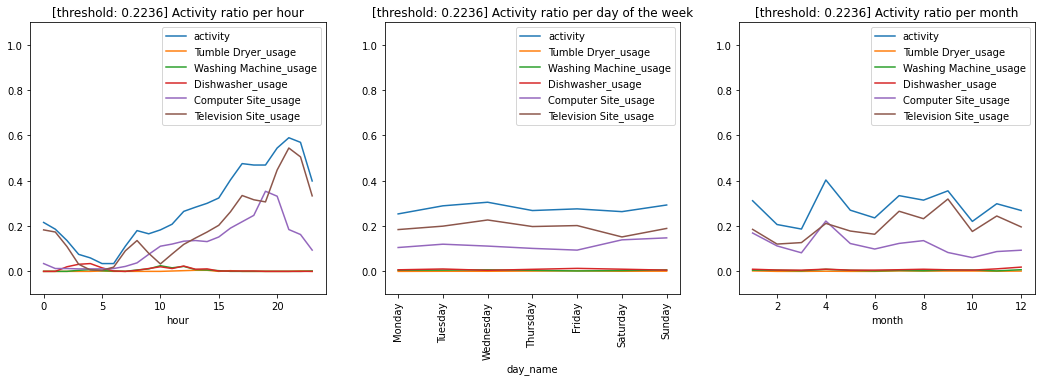

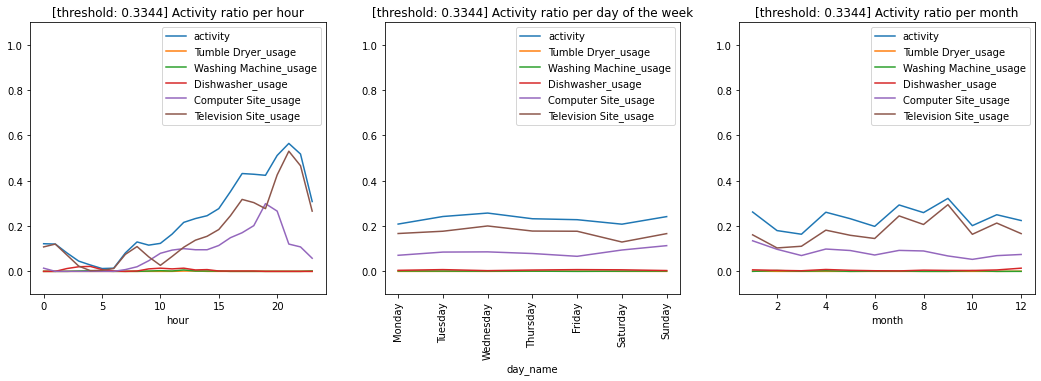

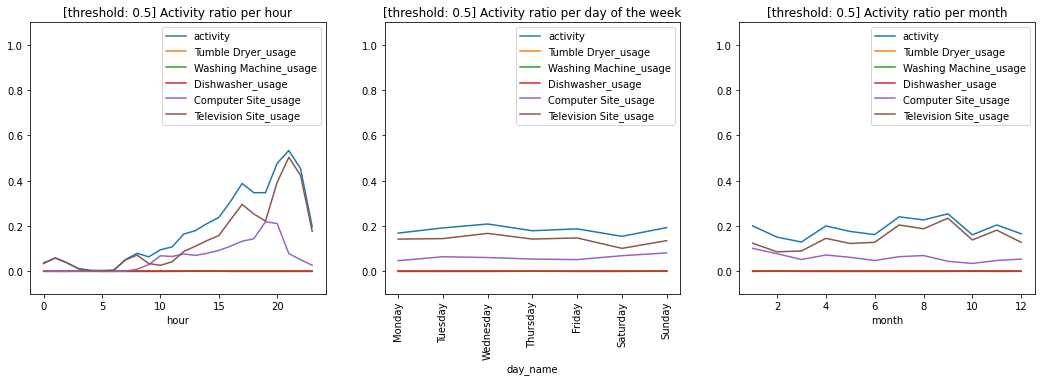

In [37]:
prep = Preparation_Agent(household)

df = helper.aggregate(household_s, '60T')
active_appliances = ['Tumble Dryer', 'Washing Machine', 'Dishwasher', 'Computer Site', 'Television Site']
thresholds = [0] + list(np.geomspace(.1, .5, 5))

prep.validate_thresholds(df, thresholds, active_appliances)

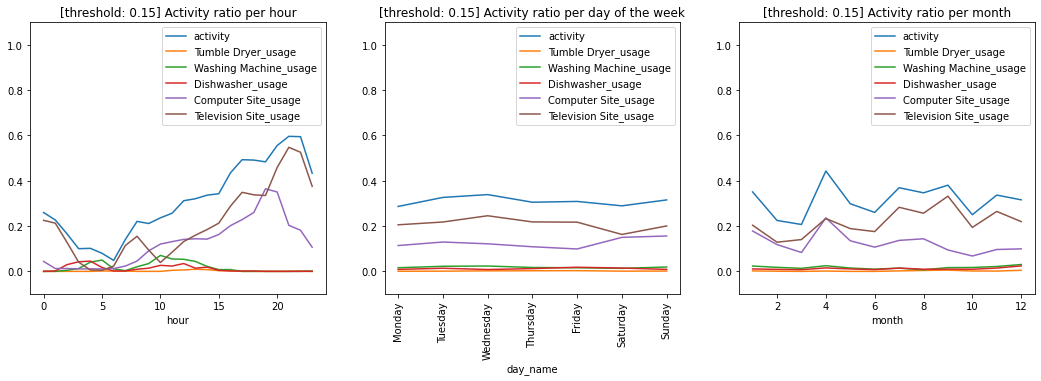

In [38]:
# According to our benshmark: The user from household one is most likely a student
# 0.15 is optimal as the noise arround 3am vanishes
prep = Preparation_Agent(household)
df = helper.aggregate(household_s, '60T')
active_appliances = ['Tumble Dryer', 'Washing Machine', 'Dishwasher', 'Computer Site', 'Television Site']
threshold = .15

prep.visualize_threshold(df, threshold, active_appliances)

### **2.5 Pipeline functions**

As the preparation agent has three subsequent agents, we will create three pipeline functions using the preparation agent’s functionality for the three following agents. All pipeline functions will be adjustable using the corresponding configuration dictionary. If further data preparation or feature creation is needed, we are able to define new functions for the preparation agent and add the new functions to the existing pipeline functions.


**Activity Pipeline**

For the activity agent, we will create the activity feature based on the truncated and scaled data using the optimal threshold. Based on the activity feature, we will create activity time lag features. Additionally, we will create further time features using the DatetimeIndex. The data for the activity agent will be aggregated to the hour level.


In [39]:
def pipeline_activity(self, df, params):
    from helper_functions import Helper
    import pandas as pd

    helper = Helper()
    df = df.copy()
    output = pd.DataFrame()

    # Data cleaning
    df = self.truncate(df, **params['truncate'],)
    df = self.scale(df, **params['scale'])

    # Aggregate to hour level
    df = helper.aggregate(df, **params['aggregate'])

    # Activity feature
    output['activity'] = self.get_activity(df, **params['activity'])
    
    ## Time feature
    output = output.join(self.get_time_feature(df, **params['time']))

    # Activity lags
    output = output.join(self.get_time_lags(output, **params['activity_lag']))

    # Dummy coding
    output = pd.get_dummies(output, drop_first=True)

    return output

# add to the Preparation_agent class
setattr(Preparation_Agent, 'pipeline_activity', pipeline_activity)
del pipeline_activity

In [40]:
truncation_params = {
    'features': 'all', 
    'factor': 1.5, 
    'verbose': 1
}

scale_params = {
    'features': 'all', 
    'kind': 'MinMax', 
    'verbose': 1
}

aggregate_params = {
    'resample_param': '60T'
}

activity_params = {
    'active_appliances': ['Tumble Dryer', 'Washing Machine', 'Dishwasher', 'Computer Site', 'Television Site'],
    'threshold': .15
}

time_params = {
    'features': ['hour', 'day_name']
}

activity_lag_params = {
    'features': ['activity'],
    'lags': [24, 48, 72]
}

activity_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate': aggregate_params,
    'activity': activity_params,
    'time': time_params,
    'activity_lag': activity_lag_params
}

In [41]:
prep = Preparation_Agent(household)
output = prep.pipeline_activity(household, activity_pipe_params)
output

[outlier truncation: Unix]: 100%|██████████| 6960008/6960008 [00:10<00:00, 658005.40it/s] 


[outlier truncation: Unix]: 0 outliers were truncated.




[outlier truncation: Aggregate]: 100%|██████████| 6959964/6959964 [00:06<00:00, 1005014.81it/s]


[outlier truncation: Aggregate]: 853913 outliers were truncated.




[outlier truncation: Fridge]: 100%|██████████| 1611328/1611328 [00:03<00:00, 463953.72it/s]


[outlier truncation: Fridge]: 60120 outliers were truncated.




[outlier truncation: Chest Freezer]: 100%|██████████| 2395354/2395354 [00:02<00:00, 872653.32it/s] 


[outlier truncation: Chest Freezer]: 207420 outliers were truncated.




[outlier truncation: Upright Freezer]: 100%|██████████| 2800342/2800342 [00:02<00:00, 1159429.83it/s]


[outlier truncation: Upright Freezer]: 197818 outliers were truncated.




[outlier truncation: Tumble Dryer]: 100%|██████████| 28117/28117 [00:00<00:00, 895270.11it/s]


[outlier truncation: Tumble Dryer]: 5934 outliers were truncated.




[outlier truncation: Washing Machine]: 100%|██████████| 156232/156232 [00:00<00:00, 979192.60it/s]


[outlier truncation: Washing Machine]: 27412 outliers were truncated.




[outlier truncation: Dishwasher]: 100%|██████████| 65272/65272 [00:00<00:00, 880364.95it/s]


[outlier truncation: Dishwasher]: 0 outliers were truncated.




[outlier truncation: Computer Site]: 100%|██████████| 756639/756639 [00:00<00:00, 893352.74it/s]


[outlier truncation: Computer Site]: 253600 outliers were truncated.




[outlier truncation: Television Site]: 100%|██████████| 1273899/1273899 [00:01<00:00, 1065550.89it/s]


[outlier truncation: Television Site]: 225564 outliers were truncated.




[outlier truncation: Electric Heater]: 100%|██████████| 6899335/6899335 [00:06<00:00, 987914.02it/s] 


[outlier truncation: Electric Heater]: 473668 outliers were truncated.




[outlier truncation: Issues]: 100%|██████████| 58183/58183 [00:00<00:00, 869871.36it/s]


[outlier truncation: Issues]: 0 outliers were truncated.


[MinMaxScaler] Finished scaling the data.


,activity,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
Time,,,,,,,,,,,
2013-10-09 13:00:00,0,13,NaN,NaN,NaN,0,0,0,0,0,1
2013-10-09 14:00:00,0,14,NaN,NaN,NaN,0,0,0,0,0,1
2013-10-09 15:00:00,0,15,NaN,NaN,NaN,0,0,0,0,0,1
2013-10-09 16:00:00,0,16,NaN,NaN,NaN,0,0,0,0,0,1
2013-10-09 17:00:00,1,17,NaN,NaN,NaN,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2015-07-10 07:00:00,0,7,0.0,0.0,0.0,0,0,0,0,0,0
2015-07-10 08:00:00,0,8,0.0,0.0,0.0,0,0,0,0,0,0
2015-07-10 09:00:00,0,9,0.0,0.0,0.0,0,0,0,0,0,0


**Usage Pipeline**

We will use the same functionality from the activity pipeline to create the activity feature for the usage agent. Furthermore, we create the device usage features for the appliances for which we will provide recommendations. As appliances for which we will provide recommendations, we used appliances that require user interaction and are time-shiftable, i.e. not bound to any specific time during the day (e.g. Television, Computer, etc.). These appliances will be called “shiftable devices”. Additionally, we create the periods since last usage feature for the shiftable devices, create time lags for activity and the shiftable devices, add further time features and aggregate the data to the day level. 


In [42]:
def pipeline_usage(self, df, params):
    from helper_functions import Helper
    import pandas as pd

    helper = Helper()
    df = df.copy()
    output = pd.DataFrame()

    # Data cleaning
    df = self.truncate(df, **params['truncate'],)
    scaled = self.scale(df, **params['scale'])

    # Aggregate to hour level
    scaled = helper.aggregate(scaled, **params['aggregate_hour'])

    # Activity feature
    output['activity'] = self.get_activity(scaled, **params['activity'])

    # Get device usage and transform to energy consumption
    for device in params['shiftable_devices']:
        output[device + '_usage'] = self.get_device_usage(scaled, device, **params['device'])

    # aggregate and convert from mean to binary
    output = helper.aggregate(output, **params['aggregate_day'])
    output = output.apply(lambda x: (x > 0).astype('int'))

    # Last usage
    output = output.join(self.get_last_usages(output, output.columns))
    
    # Time features
    output = output.join(self.get_time_feature(output, **params['time']))

    # lags
    output = output.join(self.get_time_lags(output, ['activity'] + [device+'_usage' for device in params['shiftable_devices']], [1,2,3]))
    output['active_last_2_days'] = ((output.activity_lag_1 == 1) | (output.activity_lag_2 == 1)).astype('int')

    # dummy coding
    output = pd.get_dummies(output, drop_first=True)
    return output

# add to the Preparation_agent class
setattr(Preparation_Agent, 'pipeline_usage', pipeline_usage)
del pipeline_usage

In [43]:
truncation_params = {
    'features': 'all', 
    'factor': 1.5, 
    'verbose': 1
}

scale_params = {
    'features': 'all', 
    'kind': 'MinMax', 
    'verbose': 1
}

aggregate_hour_params = {
    'resample_param': '60T'
}

activity_params = {
    'active_appliances': ['Tumble Dryer', 'Washing Machine', 'Dishwasher', 'Computer Site', 'Television Site'],
    'threshold': .15
}

shiftable_devices = ['Tumble Dryer', 'Washing Machine', 'Dishwasher'] 

device_params = {
    'threshold': 0.15
}

aggregate_day_params = {
    'resample_param': '1D'
}

time_params = {
    'features': ['day_name', 'weekend']
}

usage_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate_hour': aggregate_hour_params,
    'activity': activity_params,
    'aggregate_day': aggregate_day_params,
    'shiftable_devices': shiftable_devices, 
    'device': device_params,
    'time': time_params
}

In [44]:
prep = Preparation_Agent(household)
output = prep.pipeline_usage(household, usage_pipe_params)
output

[outlier truncation: Unix]: 100%|██████████| 6960008/6960008 [00:07<00:00, 971489.74it/s] 


[outlier truncation: Unix]: 0 outliers were truncated.




[outlier truncation: Aggregate]: 100%|██████████| 6959964/6959964 [00:07<00:00, 968846.26it/s] 


[outlier truncation: Aggregate]: 853913 outliers were truncated.




[outlier truncation: Fridge]: 100%|██████████| 1611328/1611328 [00:01<00:00, 1036175.77it/s]


[outlier truncation: Fridge]: 60120 outliers were truncated.




[outlier truncation: Chest Freezer]: 100%|██████████| 2395354/2395354 [00:02<00:00, 1107563.90it/s]


[outlier truncation: Chest Freezer]: 207420 outliers were truncated.




[outlier truncation: Upright Freezer]: 100%|██████████| 2800342/2800342 [00:02<00:00, 1136315.63it/s]


[outlier truncation: Upright Freezer]: 197818 outliers were truncated.




[outlier truncation: Tumble Dryer]: 100%|██████████| 28117/28117 [00:00<00:00, 751125.72it/s]


[outlier truncation: Tumble Dryer]: 5934 outliers were truncated.




[outlier truncation: Washing Machine]: 100%|██████████| 156232/156232 [00:00<00:00, 1014791.72it/s]


[outlier truncation: Washing Machine]: 27412 outliers were truncated.




[outlier truncation: Dishwasher]: 100%|██████████| 65272/65272 [00:00<00:00, 842837.91it/s]


[outlier truncation: Dishwasher]: 0 outliers were truncated.




[outlier truncation: Computer Site]: 100%|██████████| 756639/756639 [00:00<00:00, 955955.67it/s]


[outlier truncation: Computer Site]: 253600 outliers were truncated.




[outlier truncation: Television Site]: 100%|██████████| 1273899/1273899 [00:01<00:00, 1144213.91it/s]


[outlier truncation: Television Site]: 225564 outliers were truncated.




[outlier truncation: Electric Heater]: 100%|██████████| 6899335/6899335 [00:06<00:00, 1062366.27it/s]


[outlier truncation: Electric Heater]: 473668 outliers were truncated.




[outlier truncation: Issues]: 100%|██████████| 58183/58183 [00:00<00:00, 951601.25it/s]


[outlier truncation: Issues]: 0 outliers were truncated.


[MinMaxScaler] Finished scaling the data.


,activity,Tumble Dryer_usage,Washing Machine_usage,Dishwasher_usage,periods_since_last_activity,periods_since_last_Tumble Dryer_usage,periods_since_last_Washing Machine_usage,periods_since_last_Dishwasher_usage,weekend,activity_lag_1,...,Dishwasher_usage_lag_1,Dishwasher_usage_lag_2,Dishwasher_usage_lag_3,active_last_2_days,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
Time,,,,,,,,,,,,,,,,,,,,,
2013-10-09,1,0,0,0,NaN,NaN,NaN,NaN,0,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,1
2013-10-10,1,0,0,1,1.0,2.0,2.0,2.0,0,1.0,...,0.0,NaN,NaN,1,0,0,0,1,0,0
2013-10-11,0,0,0,0,1.0,3.0,3.0,1.0,0,1.0,...,1.0,0.0,NaN,1,0,0,0,0,0,0
2013-10-12,0,0,0,0,2.0,4.0,4.0,2.0,1,0.0,...,0.0,1.0,0.0,1,0,1,0,0,0,0
2013-10-13,0,0,0,0,3.0,5.0,5.0,3.0,1,0.0,...,0.0,0.0,1.0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-06,1,0,0,1,1.0,72.0,1.0,3.0,0,1.0,...,0.0,0.0,1.0,1,1,0,0,0,0,0
2015-07-07,1,0,0,0,1.0,73.0,2.0,1.0,0,1.0,...,1.0,0.0,0.0,1,0,0,0,0,1,0
2015-07-08,1,0,0,1,1.0,74.0,3.0,2.0,0,1.0,...,0.0,1.0,0.0,1,0,0,0,0,0,1


**Load Pipeline**

The load agent requires cleaned energy consumption data for the shiftable devices. Therefore, we calculate the device usage for these appliances based on the truncated and scaled data and return the energy consumption of the shiftable devices only if we detected a device usage. The data for the load agent will be aggregated to the hour level.


In [45]:
def pipeline_load(self, df, params):
    from helper_functions import Helper
    import pandas as pd

    helper = Helper()
    df = df.copy()
    output = pd.DataFrame()

    # Data cleaning
    df = self.truncate(df, **params['truncate'],)
    scaled = self.scale(df, **params['scale'])

    # aggregate
    df = helper.aggregate(df, **params['aggregate'])
    scaled = helper.aggregate(scaled, **params['aggregate'])

    # Get device usage and transform to energy consumption
    for device in params['shiftable_devices']:
        df[device + '_usage'] = self.get_device_usage(scaled, device, **params['device'])
        output[device] = df.apply(lambda timestamp: timestamp[device] * timestamp[device + '_usage'], axis = 1)

    return output, scaled, df

# add to the Preparation_agent class
setattr(Preparation_Agent, 'pipeline_load', pipeline_load)
del pipeline_load

In [46]:
truncation_params = {
    'features': 'all', 
    'factor': 1.5, 
    'verbose': 1
}

scale_params = {
    'features': 'all', 
    'kind': 'MinMax', 
    'verbose': 1
}

aggregate_params = {
    'resample_param': '60T'
}

shiftable_devices = ['Tumble Dryer', 'Washing Machine', 'Dishwasher'] # computer und tv sind m. E. non-shiftable, VR

device_params = {
    'threshold': 0.15
}

load_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate': aggregate_params,
    'shiftable_devices': shiftable_devices, 
    'device': device_params
}

In [47]:
prep = Preparation_Agent(household)
output, scaled, df = prep.pipeline_load(household, load_pipe_params)
output.iloc[300:360]

[outlier truncation: Unix]: 100%|██████████| 6960008/6960008 [00:06<00:00, 1095046.63it/s]


[outlier truncation: Unix]: 0 outliers were truncated.




[outlier truncation: Aggregate]: 100%|██████████| 6959964/6959964 [00:06<00:00, 1060782.38it/s]


[outlier truncation: Aggregate]: 853913 outliers were truncated.




[outlier truncation: Fridge]: 100%|██████████| 1611328/1611328 [00:02<00:00, 772983.84it/s] 


[outlier truncation: Fridge]: 60120 outliers were truncated.




[outlier truncation: Chest Freezer]: 100%|██████████| 2395354/2395354 [00:02<00:00, 1179876.75it/s]


[outlier truncation: Chest Freezer]: 207420 outliers were truncated.




[outlier truncation: Upright Freezer]: 100%|██████████| 2800342/2800342 [00:02<00:00, 1166764.38it/s]


[outlier truncation: Upright Freezer]: 197818 outliers were truncated.




[outlier truncation: Tumble Dryer]: 100%|██████████| 28117/28117 [00:00<00:00, 750824.45it/s]


[outlier truncation: Tumble Dryer]: 5934 outliers were truncated.




[outlier truncation: Washing Machine]: 100%|██████████| 156232/156232 [00:00<00:00, 1059653.62it/s]


[outlier truncation: Washing Machine]: 27412 outliers were truncated.




[outlier truncation: Dishwasher]: 100%|██████████| 65272/65272 [00:00<00:00, 881527.19it/s]


[outlier truncation: Dishwasher]: 0 outliers were truncated.




[outlier truncation: Computer Site]: 100%|██████████| 756639/756639 [00:00<00:00, 1085037.46it/s]


[outlier truncation: Computer Site]: 253600 outliers were truncated.




[outlier truncation: Television Site]: 100%|██████████| 1273899/1273899 [00:01<00:00, 1153647.28it/s]


[outlier truncation: Television Site]: 225564 outliers were truncated.




[outlier truncation: Electric Heater]: 100%|██████████| 6899335/6899335 [00:05<00:00, 1185709.08it/s]


[outlier truncation: Electric Heater]: 473668 outliers were truncated.




[outlier truncation: Issues]: 100%|██████████| 58183/58183 [00:00<00:00, 645966.74it/s]


[outlier truncation: Issues]: 0 outliers were truncated.


[MinMaxScaler] Finished scaling the data.


,Tumble Dryer,Washing Machine,Dishwasher
Time,,,
2013-10-22 01:00:00,0.0,0.000000,0.0
2013-10-22 02:00:00,0.0,0.000000,0.0
2013-10-22 03:00:00,0.0,0.000000,0.0
2013-10-22 04:00:00,0.0,0.000000,0.0
2013-10-22 05:00:00,0.0,0.000000,0.0
2013-10-22 06:00:00,0.0,0.000000,0.0
2013-10-22 07:00:00,0.0,0.000000,0.0
2013-10-22 08:00:00,0.0,0.000000,0.0
2013-10-22 09:00:00,0.0,0.000000,0.0


## **Reference List**

Murray, D., Stankovic, L., & Stankovic, V. (2017). An electrical load measurements dataset of United Kingdom households from a two-year longitudinal study [data set]. *Scientific Data*.

Wennman, H., Pietilä, A., Rissanen, H. et al. (2019) Gender, age and socioeconomic variation in 24-hour physical activity by wrist-worn accelerometers: the FinHealth 2017 Survey. *Scientific Reports* 9, 6534 (2019). https://doi.org/10.1038/s41598-019-43007-x.

## **Appendix A1: Complete Preparation Agent Class**

In [48]:
class Preparation_Agent:
    def __init__(self, REFIT_df):
        self.input = REFIT_df

    # stardard data preprocessing
    # -------------------------------------------------------------------------------------------
    def outlier_truncation(self, series, factor=1.5, verbose=0):
        from tqdm import tqdm
        import time

        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1

        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr

        output = []
        counter = 0
        for item in (
            tqdm(series, desc=f"[outlier truncation: {series.name}]")
            if verbose != 0
            else series
        ):
            if item > upper_bound:
                output.append(int(upper_bound))
                counter += 1
            elif item < lower_bound:
                output.append(int(lower_bound))
                counter +=1
                
            else:
                output.append(item)
        print(
            f"[outlier truncation: {series.name}]: {counter} outliers were truncated."
        ) if verbose != 0 else None
        return output

    def truncate(self, df, features="all", factor=1.5, verbose=0):
        import time

        output = df.copy()
        features = (
            df.select_dtypes(include=["number"]).columns
            if features == "all"
            else features
        )

        for feature in features:
            time.sleep(0.2) if verbose != 0 else None
            row_nn = (
                df[feature] != 0
            )  # truncate only the values for which the device uses energy
            output.loc[row_nn, feature] = self.outlier_truncation(
                df.loc[row_nn, feature], factor=factor, verbose=verbose
            )  # Truncatation factor = 1.5 * IQR
            print("\n") if verbose != 0 else None
        return output

    def scale(self, df, features="all", kind="MinMax", verbose=0):
        output = df.copy()
        features = (
            df.select_dtypes(include=["number"]).columns
            if features == "all"
            else features
        )

        if kind == "MinMax":
            from sklearn.preprocessing import MinMaxScaler

            scaler = MinMaxScaler()
            output[features] = scaler.fit_transform(df[features])
            print("[MinMaxScaler] Finished scaling the data.") if verbose != 0 else None
        else:
            raise InputError("Chosen scaling method is not available.")
        return output

    # feature creation
    # -------------------------------------------------------------------------------------------
    def get_device_usage(self, df, device, threshold):
        return (df.loc[:, device] > threshold).astype("int")

    def get_last_usage(self, series):
        import pandas as pd

        last_usage = []
        for idx in range(len(series)):
            shift = 1
            if pd.isna(series.shift(periods=1)[idx]):
                shift = None
            else:
                while series.shift(periods=shift)[idx] == 0:
                    shift += 1
            last_usage.append(shift)
        return last_usage

    def get_last_usages(self, df, features):
        import pandas as pd

        output = pd.DataFrame()
        for feature in features:
            output["periods_since_last_" + feature] = self.get_last_usage(df[feature])
        output.set_index(df.index, inplace=True)
        return output

    def get_activity(self, df, active_appliances, threshold):
        import pandas as pd

        active = pd.DataFrame(
            {appliance: df[appliance] > threshold for appliance in active_appliances}
        )
        return active.apply(any, axis=1).astype("int")

    def get_time_feature(self, df, features="all"):
        import pandas as pd

        functions = {
            "hour": lambda df: df.index.hour,
            "day_of_week": lambda df: df.index.dayofweek,
            "day_name": lambda df: df.index.day_name().astype("category"),
            "month": lambda df: df.index.month,
            "month_name": lambda df: df.index.month_name().astype("category"),
        }
        if features == "all":
            output = pd.DataFrame(
                {function[0]: function[1](df) for function in functions.items()}
            )
        else:
            output = pd.DataFrame(
                {
                    function[0]: function[1](df)
                    for function in functions.items()
                    if function[0] in features
                }
            )
        output.set_index(df.index, inplace=True)
        return output

    def get_time_lags(self, df, features, lags):
        import pandas as pd

        output = pd.DataFrame()
        for feature in features:
            for lag in lags:
                output[f"{feature}_lag_{lag}"] = df[feature].shift(periods=lag)
        return output

    # determining the optimal energy consumption threshold for target creation (usage, activity)
    # -------------------------------------------------------------------------------------------
    def visualize_threshold(self, df, threshold, appliances, figsize=(18, 5)):
        # data prep
        for appliance in appliances:
            df[appliance + "_usage"] = self.get_device_usage(df, appliance, threshold)
        df = df.join(self.get_time_feature(df))
        df["activity"] = self.get_activity(df, appliances, threshold)

        # plotting
        import matplotlib.pyplot as plt

        usage_cols = [column for column in df.columns if column.endswith("_usage")]
        columns = ["activity"] + usage_cols

        fig, axes = plt.subplots(1, 3, figsize=figsize)

        # hour
        hour = df.groupby("hour").mean()[columns]
        hour.plot(ax=axes[0])
        axes[0].set_ylim(-0.1, 1.1)
        axes[0].set_title(f"[threshold: {round(threshold, 4)}] Activity ratio per hour")

        # week
        usage_cols = [column for column in df.columns if column.endswith("_usage")]
        week = df.groupby("day_name").mean()[columns]
        week = week.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
        week = week.rename(index=(lambda day: day[:3]))
        week.plot(ax=axes[1])
        axes[1].set_ylim(-0.1, 1.1)        
        axes[1].set_title(
            f"[threshold: {round(threshold, 4)}] Activity ratio per day of the week"
        )

        # month
        usage_cols = [column for column in df.columns if column.endswith("_usage")]
        month = df.groupby("month").mean()[columns]
        month.plot(ax=axes[2])
        axes[2].set_ylim(-0.1, 1.1)
        axes[2].set_title(
            f"[threshold: {round(threshold, 4)}] Activity ratio per month"
        )

    def validate_thresholds(self, df, thresholds, appliances, figsize=(18, 5)):
        import time
        from tqdm import tqdm

        for threshold in tqdm(thresholds):
            self.visualize_threshold(df, threshold, appliances, figsize)
        time.sleep(0.2)
        print("\n")
        
    # pipeline functions: preparing the input for the following agents
    # -------------------------------------------------------------------------------------------
    def pipeline_activity(self, df, params):
        from helper_functions import Helper
        import pandas as pd

        helper = Helper()
        df = df.copy()
        output = pd.DataFrame()

        # Data cleaning
        df = self.truncate(
            df,
            **params["truncate"],
        )
        df = self.scale(df, **params["scale"])

        # Aggregate to hour level
        df = helper.aggregate(df, **params["aggregate"])

        # Activity feature
        output["activity"] = self.get_activity(df, **params["activity"])

        ## Time feature
        output = output.join(self.get_time_feature(df, **params["time"]))

        # Activity lags
        output = output.join(self.get_time_lags(output, **params["activity_lag"]))

        # Dummy coding
        output = pd.get_dummies(output, drop_first=True)

        return output

    def pipeline_load(self, df, params):
        from helper_functions import Helper
        import pandas as pd

        helper = Helper()
        df = df.copy()
        output = pd.DataFrame()

        # Data cleaning
        df = self.truncate(
            df,
            **params["truncate"],
        )
        scaled = self.scale(df, **params["scale"])

        # aggregate
        df = helper.aggregate(df, **params["aggregate"])
        scaled = helper.aggregate(scaled, **params["aggregate"])

        # Get device usage and transform to energy consumption
        for device in params["shiftable_devices"]:
            df[device + "_usage"] = self.get_device_usage(
                scaled, device, **params["device"]
            )
            output[device] = df.apply(
                lambda timestamp: timestamp[device] * timestamp[device + "_usage"],
                axis=1,
            )

        return output, scaled, df

    def pipeline_usage(self, df, params):
        from helper_functions import Helper
        import pandas as pd

        helper = Helper()
        df = df.copy()
        output = pd.DataFrame()

        # Data cleaning
        df = self.truncate(
            df,
            **params["truncate"],
        )
        scaled = self.scale(df, **params["scale"])

        # Aggregate to hour level
        scaled = helper.aggregate(scaled, **params["aggregate_hour"])

        # Activity feature
        output["activity"] = self.get_activity(scaled, **params["activity"])

        # Get device usage and transform to energy consumption
        for device in params["shiftable_devices"]:
            output[device + "_usage"] = self.get_device_usage(
                scaled, device, **params["device"]
            )

        # aggregate and convert from mean to binary
        output = helper.aggregate(output, **params["aggregate_day"])
        output = output.apply(lambda x: (x > 0).astype("int"))

        # Last usage
        output = output.join(self.get_last_usages(output, output.columns))

        # Time features
        output = output.join(self.get_time_feature(output, **params["time"]))

        # lags
        output = output.join(
            self.get_time_lags(
                output,
                ["activity"]
                + [device + "_usage" for device in params["shiftable_devices"]],
                [1, 2, 3],
            )
        )
        output["active_last_2_days"] = (
            (output.activity_lag_1 == 1) | (output.activity_lag_2 == 1)
        ).astype("int")

        # dummy coding
        output = pd.get_dummies(output, drop_first=True)

        return output